In [1]:
# Import necessary libraries
import pandas as pd
import joblib
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import classification_report, roc_auc_score

In [2]:
# Load training and validation data
train_df = pd.read_csv('../data/preprocessed_train.csv')
X_train = train_df.drop('FraudResult', axis=1)
y_train = train_df['FraudResult']

In [3]:
# Define parameter grid for tuning
param_grid = {
    'n_estimators': [100, 200],
    'max_depth': [None, 10, 20],
    'min_samples_split': [2, 5],
    'min_samples_leaf': [1, 2],
    'bootstrap': [True, False]
}

# Initialize RandomForest model
rf = RandomForestClassifier(random_state=42)

# Set up GridSearchCV for hyperparameter tuning
grid_search = GridSearchCV(
    estimator=rf,
    param_grid=param_grid,
    cv=3,
    scoring='f1',
    verbose=2,
    n_jobs=-1
)

# Fit grid search on training data
grid_search.fit(X_train, y_train)

Fitting 3 folds for each of 48 candidates, totalling 144 fits


GridSearchCV(cv=3, estimator=RandomForestClassifier(random_state=42), n_jobs=-1,
             param_grid={'bootstrap': [True, False],
                         'max_depth': [None, 10, 20],
                         'min_samples_leaf': [1, 2],
                         'min_samples_split': [2, 5],
                         'n_estimators': [100, 200]},
             scoring='f1', verbose=2)

In [4]:
# Print the best parameters
print("Best Hyperparameters:", grid_search.best_params_)

# Save the best tuned model
best_model = grid_search.best_estimator_
joblib.dump(best_model, '../models/rf_model_tuned.joblib')

Best Hyperparameters: {'bootstrap': False, 'max_depth': 20, 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 100}


['../models/rf_model_tuned.joblib']

[CV] END bootstrap=True, max_depth=None, min_samples_leaf=1, min_samples_split=2, n_estimators=100; total time=  14.9s
[CV] END bootstrap=True, max_depth=None, min_samples_leaf=2, min_samples_split=2, n_estimators=100; total time=  14.0s
[CV] END bootstrap=True, max_depth=None, min_samples_leaf=2, min_samples_split=2, n_estimators=100; total time=  15.1s
[CV] END bootstrap=True, max_depth=None, min_samples_leaf=2, min_samples_split=5, n_estimators=100; total time=  15.9s
[CV] END bootstrap=True, max_depth=None, min_samples_leaf=2, min_samples_split=5, n_estimators=200; total time=  29.3s
[CV] END bootstrap=True, max_depth=10, min_samples_leaf=2, min_samples_split=2, n_estimators=200; total time=  26.2s
[CV] END bootstrap=True, max_depth=20, min_samples_leaf=1, min_samples_split=2, n_estimators=100; total time=  15.2s
[CV] END bootstrap=True, max_depth=20, min_samples_leaf=1, min_samples_split=5, n_estimators=100; total time=  14.6s
[CV] END bootstrap=True, max_depth=20, min_samples_lea

[CV] END bootstrap=True, max_depth=None, min_samples_leaf=1, min_samples_split=2, n_estimators=200; total time=  29.7s
[CV] END bootstrap=True, max_depth=None, min_samples_leaf=2, min_samples_split=2, n_estimators=200; total time=  31.3s
[CV] END bootstrap=True, max_depth=10, min_samples_leaf=1, min_samples_split=2, n_estimators=200; total time=  25.5s
[CV] END bootstrap=True, max_depth=10, min_samples_leaf=1, min_samples_split=5, n_estimators=200; total time=  26.5s
[CV] END bootstrap=True, max_depth=10, min_samples_leaf=2, min_samples_split=5, n_estimators=200; total time=  25.2s
[CV] END bootstrap=True, max_depth=20, min_samples_leaf=1, min_samples_split=5, n_estimators=100; total time=  14.9s
[CV] END bootstrap=True, max_depth=20, min_samples_leaf=2, min_samples_split=2, n_estimators=100; total time=  15.7s
[CV] END bootstrap=True, max_depth=20, min_samples_leaf=2, min_samples_split=5, n_estimators=100; total time=  14.6s
[CV] END bootstrap=True, max_depth=20, min_samples_leaf=2, m

In [5]:
# Load validation data for evaluation
val_df = pd.read_csv('../data/preprocessed_val.csv')
X_val = val_df.drop('FraudResult', axis=1)
y_val = val_df['FraudResult']

# Make predictions and compute metrics
y_pred = best_model.predict(X_val)
y_proba = best_model.predict_proba(X_val)[:, 1]

In [6]:
# Print classification report and ROC AUC score
print("\nClassification Report (Validation):")
print(classification_report(y_val, y_pred))
print("ROC AUC Score:", roc_auc_score(y_val, y_proba))


Classification Report (Validation):
              precision    recall  f1-score   support

           0       1.00      1.00      1.00     19094
           1       0.83      0.87      0.85        39

    accuracy                           1.00     19133
   macro avg       0.91      0.94      0.92     19133
weighted avg       1.00      1.00      1.00     19133

ROC AUC Score: 0.9869686544034507


In [7]:
# Save predictions
predictions_df = pd.DataFrame({'Predictions': y_pred})
predictions_df.to_csv('../data/validation_predictions_tuned.csv', index=False)

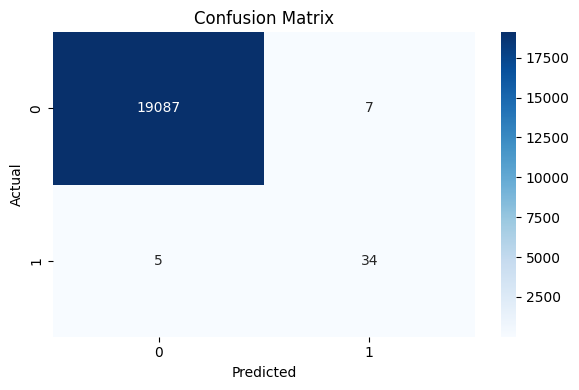

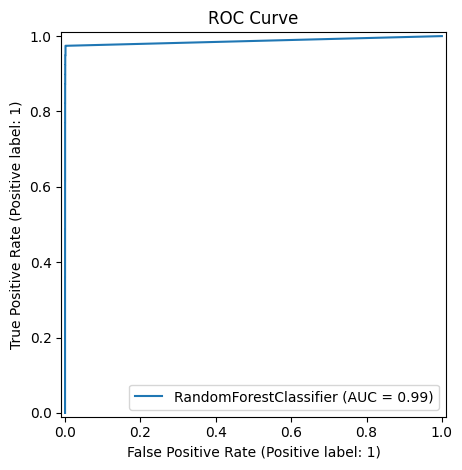

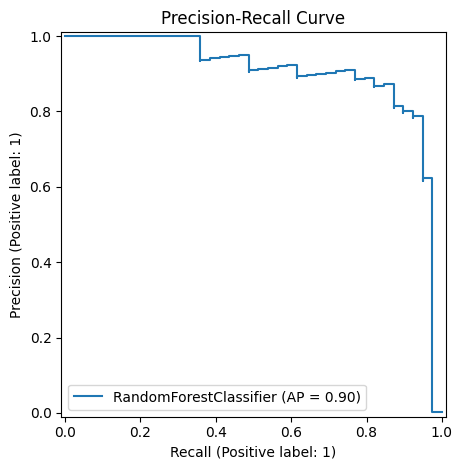

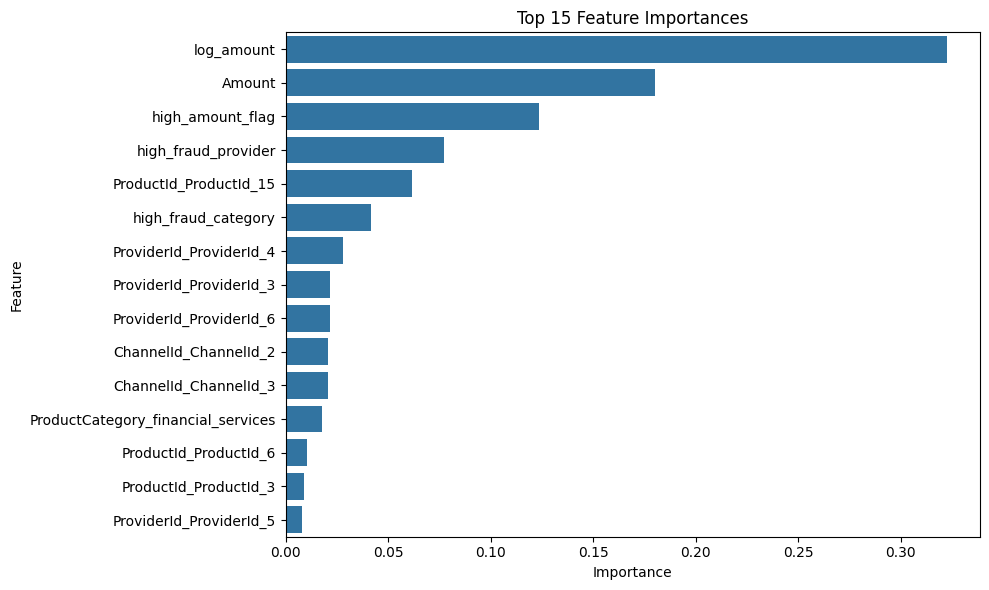

In [9]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import (
    confusion_matrix,
    RocCurveDisplay,
    PrecisionRecallDisplay
)

# 1. Confusion Matrix
cm = confusion_matrix(y_val, y_pred)
plt.figure(figsize=(6, 4))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=[0, 1], yticklabels=[0, 1])
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.tight_layout()
plt.savefig('../plots/confusion_matrix.png')
plt.show()

# 2. ROC Curve
RocCurveDisplay.from_estimator(best_model, X_val, y_val)
plt.title('ROC Curve')
plt.tight_layout()
plt.savefig('../plots/roc_curve.png')
plt.show()

# 3. Precision-Recall Curve
PrecisionRecallDisplay.from_estimator(best_model, X_val, y_val)
plt.title('Precision-Recall Curve')
plt.tight_layout()
plt.savefig('../plots/precision_recall_curve.png')
plt.show()

# 4. Feature Importance
importances = best_model.feature_importances_
features = X_val.columns
indices = importances.argsort()[::-1][:15]  # Top 15
plt.figure(figsize=(10, 6))
sns.barplot(x=importances[indices], y=features[indices])
plt.title("Top 15 Feature Importances")
plt.xlabel("Importance")
plt.ylabel("Feature")
plt.tight_layout()
plt.savefig('../plots/feature_importance.png')
plt.show()